# Problem Description

The challenge is to build CNN models to identify whether there are cancer cells in small image patches taken from larger pathology scans. The images in the dataset are 96x96 pixels in size with 3 color channels and are taken from the PCam dataset. The dataset is from the kaggle competition https://www.kaggle.com/competitions/histopathologic-cancer-detection and the task is to identify whether there is atleast one pixel of tumor tissue in the center 32x32 pixels of the image.

There are 220,025 training images and 57,458 test images. The training images are labeled as 0 or 1, where 0 indicates no tumor pixels and 1 indicates atleast one tumor pixel. The test images are unlabeled.

# Imports and utility functions

In [1]:
data_dir = '/workspace'
import keras
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

2025-04-12 11:51:49.968440: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-12 11:51:49.986915: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744458710.008285   15341 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744458710.014769   15341 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744458710.032036   15341 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
def load_training_labels(data_dir='./', num_samples=None, balanced=False):
    """
    Load training labels and optionally sample a subset of them.
    Parameters:
    - data_dir: Data directory containing the input data.
    - num_samples: Number of samples to load. If None, load all samples.
    - balanced: If True, sample an equal number of positive and negative samples.
    Returns:
    - DataFrame containing the sampled training labels.
    The DataFrame has two columns: 'id' and 'label'.
    """
    training_labels = pd.read_csv(os.path.join(data_dir, 'train_labels.csv'))
    training_labels['label'] = training_labels['label'].astype('bool')
    if num_samples is None:
        return training_labels.sample(frac=1).reset_index(drop=True)
    
    if balanced:
        pos = training_labels[training_labels['label']].sample(num_samples // 2)
        neg = training_labels[~training_labels['label']].sample(num_samples // 2)
        training_labels = pd.concat([pos, neg]).sample(frac=1).reset_index(drop=True)
    else:
        training_labels = training_labels.sample(num_samples).reset_index(drop=True)

    return training_labels


def get_training_images(training_labels, data_dir='./'):
    """
    Load training images based on the training labels dataframe which contains the image IDs.
    Parameters:
    - training_labels: DataFrame containing the training labels and image IDs.
    - data_dir: Data directory containing the input data
    Returns:
    - Numpy array of training images.
    """
    images = np.array(
        [keras.utils.img_to_array(keras.utils.load_img(os.path.join(data_dir, 'train', f'{id}.tif')))
         for id in training_labels['id']])
    return images


def get_test_images(data_dir='./'):
    """
    Load test images from the specified data_dir
    Parameters:
    - data_dir: Data directory containing the input data.
    Returns:
    - Numpy array of test images
    - List of test image IDs
    """
    test_image_files = [f for f in os.listdir(os.path.join(data_dir, "test")) if f.endswith(".tif")]
    test_ids = [Path(f).stem for f in test_image_files]
    test_images = np.array(
        [keras.utils.img_to_array(keras.utils.load_img(os.path.join(data_dir, 'test', f)))
         for f in test_image_files])
    return test_images, test_ids


def plot_training_history(history):
    """
    Plot the training and validation loss and accuracy against the number of epochs.
    Parameters:
    - history: History object returned by the fit method of a Keras model
    """
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()


# Exploratory Data Analysis (EDA)


In [3]:
# Read the training labels
training_labels = load_training_labels(data_dir)
print(training_labels.shape)
print(training_labels.head())
print(training_labels['label'].value_counts())
print(training_labels['label'].value_counts(normalize=True))

(220025, 2)
                                         id  label
0  9a1c0125de70a77df3e743bdfc80ae742bc759bd   True
1  85303769ec1657ab642b2dbc8e8f478f8a5b911e  False
2  365c43857fd6e33f85f5e19067d3735b67cca550  False
3  44d4eafd7d65c32b45c47f0916dde687f46b1b86  False
4  f671c84cbb83b213251350bc953ae7b2ac204ebc   True
label
False    130908
True      89117
Name: count, dtype: int64
label
False    0.594969
True     0.405031
Name: proportion, dtype: float64


As we can see above, the dataset is slightly imbalanced. There are 89117 positive samples and 130908 negative samples with a proportion of roughly 0.4 to 0.6.


Visualizing a few sample images from the dataset.

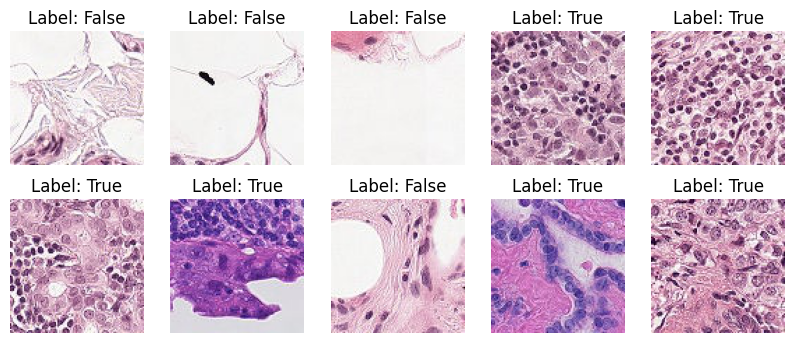

In [4]:
sample_training_labels = training_labels.sample(10)
sample_images = get_training_images(sample_training_labels, data_dir)
sample_labels = sample_training_labels['label']

plt.figure(figsize=(10, 4))
for image, label, i in zip(sample_images, sample_labels, range(len(sample_images))):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.astype('uint8'))
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.show()

# Model building, tuning and analysis

Starting with a few helper functions to create cnn models which will help later in tuning the model without repeating all the code for creating the model.

In [13]:
def create_cnn_layers(cnn_layers=[(48, 3, True), (96, 3, True), (192, 3, True)], regularization=None, dropout_rate=0.25):
    """
    Create a sequential CNN model with the specified layers.
    Parameters:
    - cnn_layers: List of tuples, where each tuple contains (number of filters, kernel size, use_max_pooling_after_this_layer).
    - regularization: String, either 'batch' for batch normalization or 'dropout' for dropout regularization.
    - dropout_rate: Float, dropout rate if dropout regularization is used.
    Returns:
    - A Keras Sequential model.
    """
    output = keras.Sequential()
    for layer in cnn_layers:
        output.add(layers.Conv2D(layer[0], layer[1], activation='relu'))
        if layer[2]:
            output.add(layers.MaxPooling2D())
        if regularization == 'batch':
            output.add(layers.BatchNormalization())
        elif regularization == 'dropout':
            output.add(layers.Dropout(dropout_rate))
    return output


def create_cnn_model(cnn_layers, center_crop=None, image_rescaling=False, fc_layers=[64], fc_regularization=None, fc_dropout_rate=0.5):
    """
    Create a CNN model with the specified CNN layers and fully connected layers.
    Parameters:
    - cnn_layers: A Keras Sequential model containing the CNN layers.
    - center_crop: Integer, size of the center crop. (in case we don't want to use the full 96x96 image)
    - image_rescaling: Boolean, whether to rescale the channel values in each pixel to be in 0-1 instead of 0-255.
    - fc_layers: List of integers, number of units in each fully connected layer.
    - fc_regularization: String, either 'batch' for batch normalization or 'dropout' for dropout regularization.
    - fc_dropout_rate: Float, dropout rate if dropout regularization is used.
    Returns:
    - A Keras Sequential model.
    """
    model = keras.Sequential([
        layers.InputLayer(shape=(96, 96, 3)),
    ])
    if center_crop is not None:
        model.add(layers.CenterCrop(center_crop, center_crop))

    if image_rescaling:
        model.add(layers.Rescaling(1. / 255))

    model.add(cnn_layers)
    model.add(layers.Flatten())
    for n_units in fc_layers:
        model.add(layers.Dense(n_units, activation='relu'))
        if fc_regularization == 'batch':
            model.add(layers.BatchNormalization())
        elif fc_regularization == 'dropout':
            model.add(layers.Dropout(fc_dropout_rate))

    model.add(layers.Dense(1, activation='sigmoid'))
    return model


def train_model(model, model_name, X, y, epochs=100, batch_size=32, validation_split=0.2,
                optimizer='Adam', loss='binary_crossentropy',
                plot_history=True):
    """
    Trains a Keras model with the given data and saves the best weights based on validation AUC.
    Stops early if there is no improvement in validation AUC for 10 epochs.
    Using validation AUC for calculating best weights as this is the scoring critieria
    for the kaggle competition.
    Parameters:
    - model: Keras model to train.
    - model_name: String, name of the model used for naming the weights file.
    - X: Training data.
    - y: Training labels.
    - epochs: Integer, number of epochs to train.
    - batch_size: Integer, batch size for training.
    - validation_split: Float, fraction of data to use for validation.
    - optimizer: Keras optimizer.
    - loss: Keras loss function.
    - plot_history: Boolean, whether to plot the training history.
    Returns:
    - Trained Keras model with the best weights loaded.
    """
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', 'AUC'])
    checkpointer = keras.callbacks.ModelCheckpoint(
        f'{model_name}.best_weights.keras', 
        save_best_only=True,
        verbose=0,
        monitor='val_AUC',
        mode='max')
    early_stopping = keras.callbacks.EarlyStopping(
        patience=10,
        verbose=0,
        monitor='val_AUC',
        mode='max')

    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, 
                        callbacks=[checkpointer, early_stopping])
    
    if plot_history:
        plot_training_history(history)

    model.load_weights(f'{model_name}.best_weights.keras')
    return model # , history


def evaluate_model_and_print_results(model, X_test, y_test):
    """
    Evaluates the model on the test data and prints the results.
    Parameters:
    - model: Keras model to evaluate.
    - X_test: Test data.
    - y_test: Test labels.
    """
    test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')
    print(f'Test AUC: {test_auc}')


def generate_submission(model, test_images, test_ids, model_name):
    """
    Generates a submission file for the test data.
    Parameters:
    - model: Keras model to use for predictions.
    - test_images: numpy array containing test image data.
    - test_ids: Test IDs.
    - model_name: Name of the model. Use for naming the submission file.
    """
    test_predictions = model.predict(test_images)
    submission = pd.DataFrame({"id": test_ids, "label": test_predictions.flatten()})
    output_file = f'submission_{model_name}.csv'
    submission.to_csv(output_file, index=False)
    print(f"Submission saved to {output_file}")


### Plan

I am going to read all the images and split off 25% of it to use for testing the models (as the Kaggle test data doesn't have labels).
I will use the AUC (Area under the ROC curve) on this test data to tune the model architecture and hyperparamters and then submit the results of all the models on the kaggle test images at the end.

### Preparing the training data


In [6]:
from sklearn.model_selection import train_test_split

X_train = get_training_images(training_labels, data_dir)
y_train = training_labels['label'].values

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)



(165018, 96, 96, 3)
(165018,)
(55007, 96, 96, 3)
(55007,)


I will use X_train and y_train for training (and part of it for validation) and X_test and y_test for testing/evaluating the models.


### Initial model
I will start with an initial model with 3 cnn layers with max pooling after each layer and 1 fully connected layer. Since the task is to detect tumor tissue in the center 32x32 patch, instead of using the full 96x96 image, I will crop it to half the size in each dimension (i.e to 48x48) in the first layer of my model.

In [7]:
cnn_layers = create_cnn_layers(
    cnn_layers=[(48, 3, True), (96, 3, True), (192, 3, True)])

cnn_layers.summary()

model1 = create_cnn_model(cnn_layers, center_crop=48, image_rescaling=False, fc_layers=[256])
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ center_crop (CenterCrop)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 4, 4, 192)      │       208,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 995,937 (3.80 MB)

 Trainable params: 995,937 (3.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


I0000 00:00:1744458824.426259   15620 service.cc:152] XLA service 0x79ae7801d2e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744458824.426335   15620 service.cc:160]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2025-04-12 11:53:44.567341: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744458824.797244   15620 cuda_dnn.cc:529] Loaded cuDNN version 90300
Could not load symbol cuFuncGetName. Error: /usr/lib/x86_64-linux-gnu/libcuda.so.1: undefined symbol: cuFuncGetName


  22/4126 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - AUC: 0.5021 - accuracy: 0.5179 - loss: 35.4177   

I0000 00:00:1744458826.838112   15620 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4126/4126 ━━━━━━━━━━━━━━━━━━━━ 46s 10ms/step - AUC: 0.8030 - accuracy: 0.7451 - loss: 1.0783 - val_AUC: 0.8584 - val_accuracy: 0.7949 - val_loss: 0.4596
Epoch 2/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - AUC: 0.8574 - accuracy: 0.7900 - loss: 0.4610 - val_AUC: 0.8726 - val_accuracy: 0.8032 - val_loss: 0.4355
Epoch 3/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - AUC: 0.8743 - accuracy: 0.8047 - loss: 0.4351 - val_AUC: 0.8854 - val_accuracy: 0.8113 - val_loss: 0.4174
Epoch 4/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - AUC: 0.8843 - accuracy: 0.8118 - loss: 0.4189 - val_AUC: 0.8647 - val_accuracy: 0.8018 - val_loss: 0.4502
Epoch 5/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - AUC: 0.8870 - accuracy: 0.8165 - loss: 0.4130 - val_AUC: 0.8923 - val_accuracy: 0.8247 - val_loss: 0.4012
Epoch 6/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - AUC: 0.8991 - accuracy: 0.8270 - loss: 0.3920 - val_AUC: 0.8982 - val_accuracy: 0.8333 - val_loss: 0.3921
Epoch 7/100
4126/4126 ━━━━━

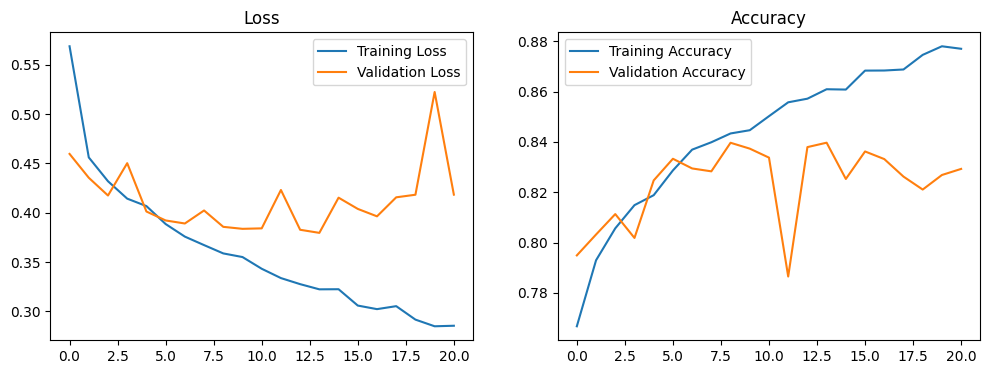

In [8]:
model1 = train_model(model1, 'model1', X_train, y_train)


In [9]:
evaluate_model_and_print_results(model1, X_test, y_test)

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - AUC: 0.9113 - accuracy: 0.8355 - loss: 0.3801
Test Loss: 0.38218867778778076
Test Accuracy: 0.8353482484817505
Test AUC: 0.9107226729393005


I got an accuracy of 0.84 on the test data and an AUC of 0.91 with this model

### Model tuning

Now I am going to rescale the images and add batch regularization to both the cnn layers and the fully connected layers to see if it improves the test scores.

In [14]:
cnn_layers = create_cnn_layers(
    cnn_layers=[(48, 3, True), (96, 3, True), (192, 3, True)],
    regularization='batch')

cnn_layers.summary()

model2 = create_cnn_model(cnn_layers, center_crop=48, image_rescaling=True, fc_layers=[256], fc_regularization='batch')
model2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ center_crop_3 (CenterCrop)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 4, 4, 192)      │       210,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 998,305 (3.81 MB)

 Trainable params: 997,121 (3.80 MB)

 Non-trainable params: 1,184 (4.62 KB)

Epoch 1/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 50s 11ms/step - AUC: 0.8534 - accuracy: 0.7887 - loss: 0.4681 - val_AUC: 0.9001 - val_accuracy: 0.7901 - val_loss: 0.4597
Epoch 2/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - AUC: 0.8996 - accuracy: 0.8307 - loss: 0.3889 - val_AUC: 0.8563 - val_accuracy: 0.7478 - val_loss: 0.6609
Epoch 3/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - AUC: 0.9237 - accuracy: 0.8559 - loss: 0.3407 - val_AUC: 0.9183 - val_accuracy: 0.8496 - val_loss: 0.3515
Epoch 4/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - AUC: 0.9352 - accuracy: 0.8683 - loss: 0.3143 - val_AUC: 0.9279 - val_accuracy: 0.8652 - val_loss: 0.3362
Epoch 5/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - AUC: 0.9483 - accuracy: 0.8837 - loss: 0.2823 - val_AUC: 0.9097 - val_accuracy: 0.8329 - val_loss: 0.3882
Epoch 6/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - AUC: 0.9593 - accuracy: 0.8984 - loss: 0.2511 - val_AUC: 0.8473 - val_accuracy: 0.7685 - val_loss: 0.7020
Epoch 7/100
412

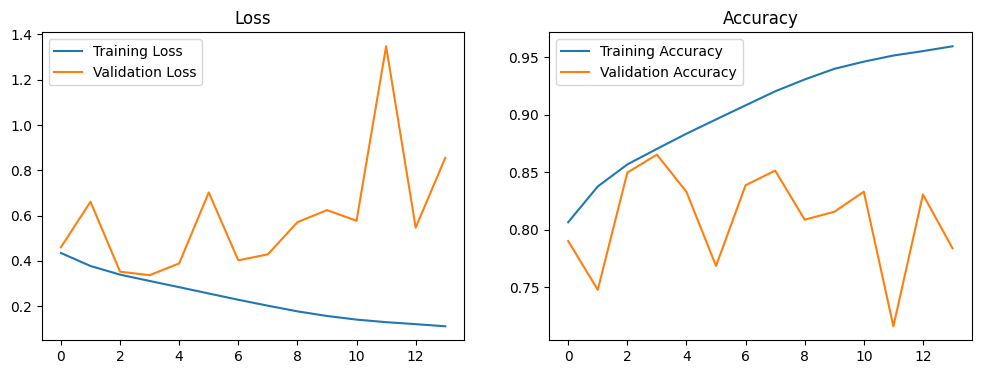

In [15]:
model2 = train_model(model2, 'model2', X_train, y_train)


In [16]:
evaluate_model_and_print_results(model2, X_test, y_test)

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - AUC: 0.9313 - accuracy: 0.8681 - loss: 0.3287
Test Loss: 0.32658272981643677
Test Accuracy: 0.8702528476715088
Test AUC: 0.9319670796394348


Accuracy improved to 0.87 and AUC to 0.93 with Batch normalization.

Using dropout instead of batch regularization (for both cnn layers and fully connected layers) and seeing if it improves the test scores

Epoch 1/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 48s 10ms/step - AUC: 0.8163 - accuracy: 0.7570 - loss: 0.5092 - val_AUC: 0.8783 - val_accuracy: 0.7944 - val_loss: 0.4559
Epoch 2/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - AUC: 0.8680 - accuracy: 0.8004 - loss: 0.4440 - val_AUC: 0.8847 - val_accuracy: 0.8118 - val_loss: 0.4233
Epoch 3/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - AUC: 0.8816 - accuracy: 0.8127 - loss: 0.4232 - val_AUC: 0.8721 - val_accuracy: 0.7937 - val_loss: 0.4438
Epoch 4/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - AUC: 0.8883 - accuracy: 0.8184 - loss: 0.4115 - val_AUC: 0.9037 - val_accuracy: 0.8254 - val_loss: 0.3951
Epoch 5/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - AUC: 0.8938 - accuracy: 0.8244 - loss: 0.4020 - val_AUC: 0.8999 - val_accuracy: 0.8154 - val_loss: 0.4075
Epoch 6/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - AUC: 0.8967 - accuracy: 0.8272 - loss: 0.3964 - val_AUC: 0.8911 - val_accuracy: 0.7912 - val_loss: 0.4397
Epoch 7/100
412

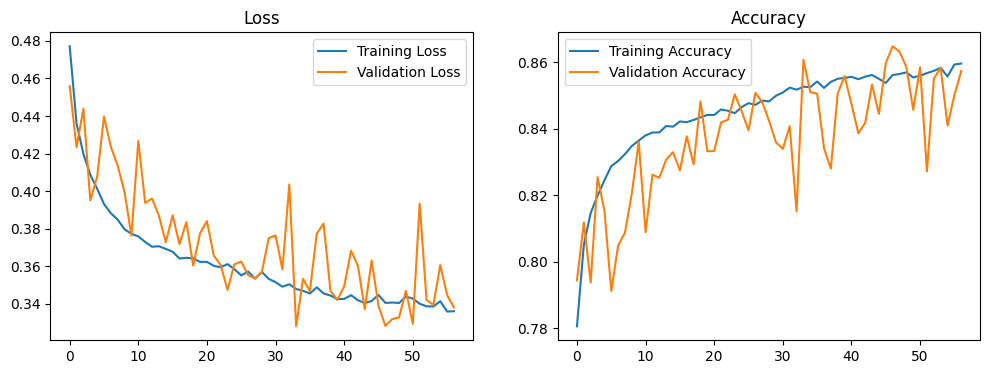

In [17]:
cnn_layers = create_cnn_layers(
    cnn_layers=[(48, 3, True), (96, 3, True), (192, 3, True)],
    regularization='dropout',
    dropout_rate=0.25)


model3 = create_cnn_model(cnn_layers, center_crop=48, image_rescaling=True, 
                          fc_layers=[256], fc_regularization='dropout',
                          fc_dropout_rate=0.5)

model3 = train_model(model3, 'model3', X_train, y_train)


In [18]:
evaluate_model_and_print_results(model3, X_test, y_test)

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - AUC: 0.9327 - accuracy: 0.8676 - loss: 0.3264
Test Loss: 0.32448339462280273
Test Accuracy: 0.8663442730903625
Test AUC: 0.9340607523918152


With dropout, I am getting an accuracy of 0.87 and an AUC of 0.93 on the test data which is same as with batch normalization. 
But looking at the train vs validation curves, seems like this model with dropout is overfitting a lot less compared to with batch normalization.
So I am going to increase the number of fc layers to 512 and see whether it improves this model's performance.

Epoch 1/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 49s 11ms/step - AUC: 0.8184 - accuracy: 0.7559 - loss: 0.5094 - val_AUC: 0.8834 - val_accuracy: 0.8145 - val_loss: 0.4173
Epoch 2/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - AUC: 0.8740 - accuracy: 0.8057 - loss: 0.4340 - val_AUC: 0.8974 - val_accuracy: 0.8282 - val_loss: 0.3950
Epoch 3/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - AUC: 0.8883 - accuracy: 0.8192 - loss: 0.4111 - val_AUC: 0.8925 - val_accuracy: 0.8111 - val_loss: 0.4223
Epoch 4/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - AUC: 0.8945 - accuracy: 0.8238 - loss: 0.3996 - val_AUC: 0.9023 - val_accuracy: 0.8287 - val_loss: 0.3839
Epoch 5/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - AUC: 0.8976 - accuracy: 0.8267 - loss: 0.3950 - val_AUC: 0.9051 - val_accuracy: 0.8344 - val_loss: 0.3792
Epoch 6/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - AUC: 0.9028 - accuracy: 0.8313 - loss: 0.3848 - val_AUC: 0.9091 - val_accuracy: 0.8372 - val_loss: 0.3734
Epoch 7/100
412

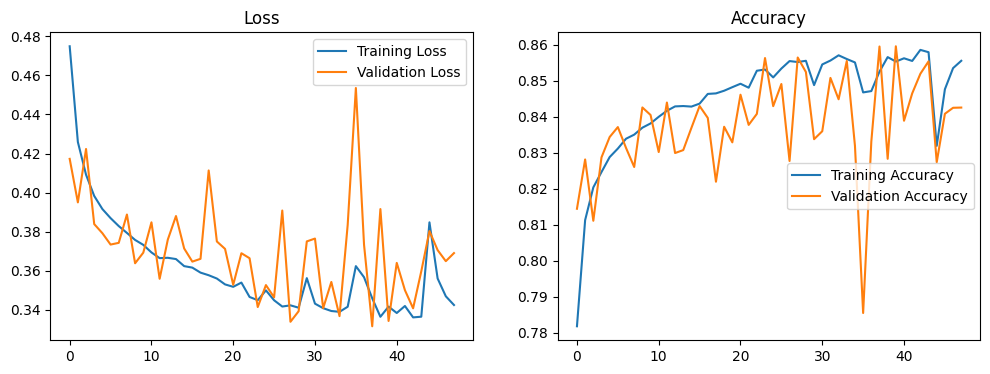

In [20]:
cnn_layers = create_cnn_layers(
    cnn_layers=[(48, 3, True), (96, 3, True), (192, 3, True)],
    regularization='dropout',
    dropout_rate=0.25)


model4 = create_cnn_model(cnn_layers, center_crop=48, image_rescaling=True, 
                          fc_layers=[512], fc_regularization='dropout',
                          fc_dropout_rate=0.5)

model4 = train_model(model4, 'model4', X_train, y_train)

In [21]:
evaluate_model_and_print_results(model4, X_test, y_test)

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - AUC: 0.9299 - accuracy: 0.8618 - loss: 0.3282
Test Loss: 0.32791218161582947
Test Accuracy: 0.8616721630096436
Test AUC: 0.9303576350212097


Similar test accuracy and AUC as before. 

Now checking if using the full 96x96 image patches with an additional layer is going to have any improvement on the test scores considering how well this model is resisting overfitting.

Epoch 1/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 79s 18ms/step - AUC: 0.8076 - accuracy: 0.7467 - loss: 0.5173 - val_AUC: 0.9050 - val_accuracy: 0.7768 - val_loss: 0.4673
Epoch 2/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 65s 16ms/step - AUC: 0.9045 - accuracy: 0.8342 - loss: 0.3829 - val_AUC: 0.9300 - val_accuracy: 0.8589 - val_loss: 0.3356
Epoch 3/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 65s 16ms/step - AUC: 0.9240 - accuracy: 0.8542 - loss: 0.3424 - val_AUC: 0.9354 - val_accuracy: 0.8589 - val_loss: 0.3435
Epoch 4/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 65s 16ms/step - AUC: 0.9296 - accuracy: 0.8598 - loss: 0.3303 - val_AUC: 0.9383 - val_accuracy: 0.8550 - val_loss: 0.3274
Epoch 5/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 65s 16ms/step - AUC: 0.9380 - accuracy: 0.8701 - loss: 0.3098 - val_AUC: 0.9487 - val_accuracy: 0.8766 - val_loss: 0.2912
Epoch 6/100
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 66s 16ms/step - AUC: 0.9408 - accuracy: 0.8762 - loss: 0.3022 - val_AUC: 0.9501 - val_accuracy: 0.8708 - val_loss: 0.3139
Epoch 7/10

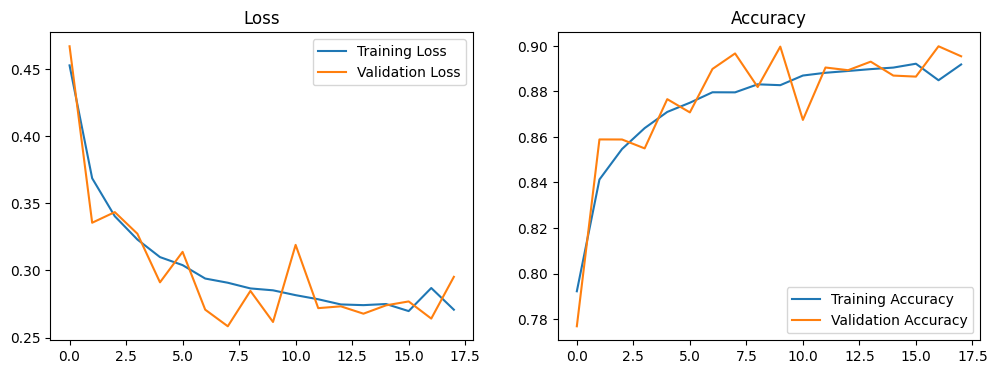

In [23]:
cnn_layers = create_cnn_layers(
    cnn_layers=[(48, 3, True), (96, 3, True), (192, 3, True), (384, 3, True)],
    regularization='dropout',
    dropout_rate=0.25)

model5 = create_cnn_model(cnn_layers, center_crop=None, image_rescaling=True, 
                          fc_layers=[768], fc_regularization='dropout',
                          fc_dropout_rate=0.5)

model5 = train_model(model5, 'model5', X_train, y_train)


In [24]:
evaluate_model_and_print_results(model5, X_test, y_test)

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - AUC: 0.9630 - accuracy: 0.8996 - loss: 0.2506
Test Loss: 0.25138306617736816
Test Accuracy: 0.9002854228019714
Test AUC: 0.9631376266479492


With an accuracy of 0.9 and AUC of 0.96, this is a noticeable improvement over the previous scores.

Now checking to see how these models perform on kaggle test data.

In [26]:
test_images, test_ids = get_test_images(data_dir)
print(test_images.shape)

(57458, 96, 96, 3)


In [27]:
generate_submission(model1, test_images, test_ids, 'model1')
generate_submission(model2, test_images, test_ids, 'model2')
generate_submission(model3, test_images, test_ids, 'model3')
generate_submission(model4, test_images, test_ids, 'model4')
generate_submission(model5, test_images, test_ids, 'model5')

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
Submission saved to submission_model1.csv
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
Submission saved to submission_model2.csv
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Submission saved to submission_model3.csv
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
Submission saved to submission_model4.csv
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step
Submission saved to submission_model5.csv


# Conclusion

Summarizing the results in a table

| Model                 |   test_acc   |   test_AUC   |   kaggle private score  | kaggle public score |
| --------------------- | ------------ | ------------ | ----------------------- | ------------------- |
| model1 (unnormalized) |     0.84     |    0.91      |         0.8571          |      0.8939         |
| model2 (batch)        |     0.87     |    0.93      |         0.8200          |      0.8832         |
| model3 (dropout)      |     0.86     |    0.93      |         0.8731          |      0.9211         |
| model4 (more fc units)|     0.86     |    0.93      |         0.8615          |      0.9167         |
| model5 (entire image) |     0.90     |    0.96      |         0.8898          |      0.9391         |

Looking at the above results, even though there isn't any difference between batch normalization and dropout on my test data, the training vs validation loss does show that batch normalization is overfitting more than dropout and the kaggle scores do show that dropout performed better on this model.

Also using the full 96x96 image instead of a center crop gave better results even though the problem is detecting tumor tissue in just the center 32x32 patch. This is probably because if there is tumor in the center patch, there are probably tumor cells or other indicators in the surrounding part of the image too. 

Increasing the number of units in the fully connected layer didn't actually make any noticeable difference. Seems like 256 unit were more than enough here.

# Further work

There is still a lot of hyperparamter tuning we can do including playing around with optmizers, loss functions, learning rate, number of units in each cnn layer and number of fc layers and number of hidden units in each etc.

This might help us to further improve the score but since there isn't any obvious direction to choose, I might have to brute force all possible combinations which is very expensive in terms of compute time. 

So concluding with these results.

